In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import norm
from tqdm.auto import tqdm

import sys
sys.path.append('../utils')
from utils import *
from data_retrieve import *
from gbm import *

In [131]:
last_id = 287
backtest_start = 46
backtest_end = 111
h = 0.01

In [132]:
tickers = ['ROG_Last_Price', 'CFR_Last_Price', 'ZURN_Last_Price']

# Getting Delta

In [ ]:
deltas = {}
gammas = {}

for t in tickers:
    gammas[t] = []
    deltas[t] = []
    
prices = []
h = 0.01

for current_id in tqdm(range(backtest_start, backtest_end)):
    payoff = []
    result, tickers, discounts = MultivariateGBMSimulationTS(s0=close.iloc[current_id], n_paths=100, current_id=current_id, window_size=30, implied_volatility=True)

    old_path_rog = combined_df['ROG_Last_Price'].iloc[:current_id]
    old_path_cfr = combined_df['CFR_Last_Price'].iloc[:current_id]
    old_path_zurn = combined_df['ZURN_Last_Price'].iloc[:current_id]
    payoff_up = {}
    payoff_down = {}
    for t in tickers:
        payoff_up[t] = []
        payoff_down[t] = []
        
    for i in range(result.shape[1]):
        path_rog = np.append(old_path_rog, result[0][i].flatten())
        path_cfr = np.append(old_path_cfr, result[1][i].flatten())
        path_zurn = np.append(old_path_zurn, result[2][i].flatten())

        normal = payoff_func(path_rog, path_cfr, path_zurn, combined_df.iloc[current_id]['Date'], risk_free=discounts, risk_neutral=False, verbose=False)
        up = payoff_func(path_rog * (1 + h), path_cfr, path_zurn, combined_df.iloc[current_id]['Date'], risk_free=discounts, risk_neutral=False, verbose=False)
        down = payoff_func(path_rog * (1 - h), path_cfr, path_zurn, combined_df.iloc[current_id]['Date'], risk_free=discounts, risk_neutral=False, verbose=False)
        payoff_up['ROG_Last_Price'].append(up)
        payoff_down['ROG_Last_Price'].append(down)

        up = payoff_func(path_rog, path_cfr * (1 + h), path_zurn, combined_df.iloc[current_id]['Date'], risk_free=discounts, risk_neutral=False, verbose=False)
        down = payoff_func(path_rog, path_cfr * (1 - h), path_zurn, combined_df.iloc[current_id]['Date'], risk_free=discounts, risk_neutral=False, verbose=False)
        payoff_up['CFR_Last_Price'].append(up)
        payoff_down['CFR_Last_Price'].append(down)

        up = payoff_func(path_rog, path_cfr, path_zurn * (1 + h), combined_df.iloc[current_id]['Date'], risk_free=discounts, risk_neutral=False, verbose=False)
        down = payoff_func(path_rog, path_cfr, path_zurn * (1 - h), combined_df.iloc[current_id]['Date'], risk_free=discounts, risk_neutral=False, verbose=False)
        payoff_up['ZURN_Last_Price'].append(up)
        payoff_down['ZURN_Last_Price'].append(down)
        payoff.append(normal)
    
    for t in tickers:
        deltas[t].append(np.exp(-0.01107 * (last_id - current_id)) * \
        np.sum(np.subtract(payoff_up[t], payoff_down[t])) / (2 * h * len(payoff_up)))
        gammas[t].append(np.exp(-0.01107 * (last_id - current_id)) * \
        np.sum(np.add(np.subtract(payoff_up[t], np.multiply(payoff, 2)), payoff_down[t])) / (h * h))
    prices.append(np.mean(payoff))



  0%|          | 0/65 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 65.18it/s]


1.0080152945283514


100%|██████████| 100/100 [00:01<00:00, 71.31it/s]


1.0073367310973573


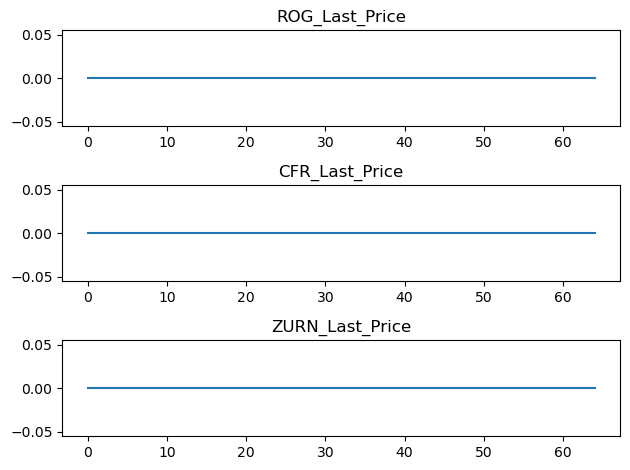

In [ ]:
f, axes = plt.subplots(3, 1)
axes = axes.flatten()
for i, t in enumerate(tickers):
    axes[i].plot(deltas[t])
    axes[i].set_title(t)

plt.tight_layout()

In [ ]:
gammas

{'ROG_Last_Price': [0.0,
  8.813438252440156e-11,
  8.911545033053611e-11,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  9.523549546485808e-11,
  0.0],
 'CFR_Last_Price': [-39884.08734134247,
  582522.0795407997,
  3.5646180132214443e-10,
  -491796.45066264377,
  9.111046977360194e-11,
  -2.763739976774643e-10,
  -284801.3076435603,
  -238667.64012134096,
  9.523549546485808e-11,
  1.9259121860762555e-10],
 'ZURN_Last_Price': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}

In [ ]:
price_1 = [prices.copy]

/home/bach/mh4518_simulation_in_fin/notebooks/../utils/utils.py:145: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  real_price['Date'] = pd.to_datetime(real_price['Date'], dayfirst=True)


[996.4 997.1 995.8 995.4 996.5 992.7 978.2 978.6 983.8 989. ]
2430.625986638445


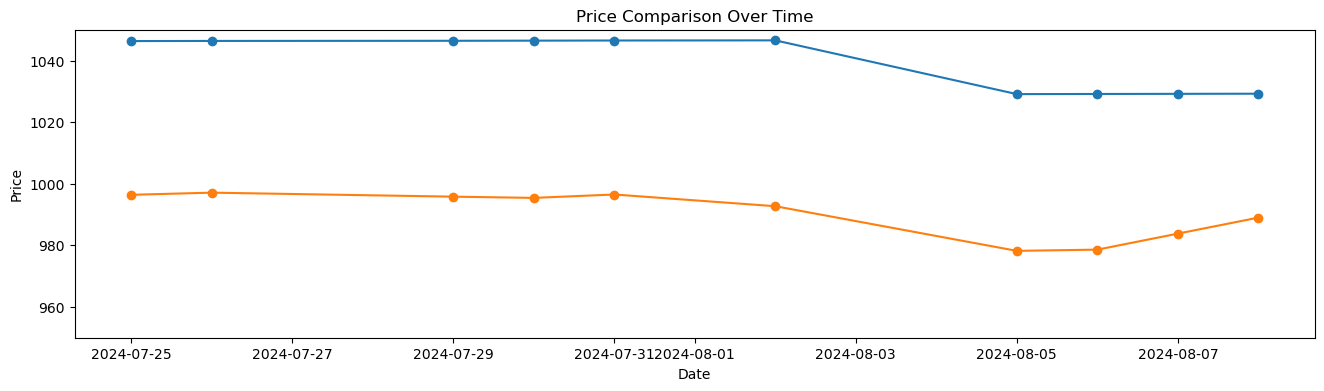

In [ ]:
combined_df = retrieve_data()

evaluation_plot(
    backtest_start,
    backtest_end,
    combined_df,
    price_1,
    ylim=(950, 1050)
    )

In [ ]:
df_bond = retrieve_bond()